In [1]:
## Preliminaries

using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using AdvancedHMC
using ArviZ
using BumpCosmologyGWTC3
using CairoMakie
using Colors
using Cosmology
using DataFrames
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using InferenceObjects
#using Interpolations
using JSON
using LaTeXStrings
using MCMCChainsStorage
using NCDatasets
using PairPlots
using PolyLog
using PopModels
using Printf
using ProgressLogging
using Random
using StatsBase
using SpecialFunctions
using StatsFuns
using Trapz
using Turing
using Unitful
using UnitfulAstro
using UnitfulChainRules

include("plots.jl")

  Activating project at `~/35Msun_GWTC3/Mc_cut`


h_plot (generic function with 1 method)

# Load GWTC-3 Parameter Estimation and Selection Samples

In [2]:
## Samples and Selection

## Set up paths
struct Paths
    gwtc_2_dir::String
    gwtc_3_dir::String
    evt_table_file::String
    o1o2o3_sensitivity_file::String
end

paths = Paths(
    "/mnt/home/ccalvk/ceph/GWTC-2.1", 
    "/mnt/home/ccalvk/ceph/GWTC-3", 
    "/mnt/home/ccalvk/ceph/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json",
    "/mnt/home/ccalvk/ceph/sensitivity-estimates/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5"
)

## Output Directory for Plots and Astro Comparison Plot
outdir = "/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/"
savepath = "../data/Astro_Compare_Feature.h5" #first run m1_marginal to write h5py file, for rest, it will append

## Plot Specifications
xlabelsize = 30
ylabelsize = 30
xticklabelsize = 20
yticklabelsize = 20
titlesize = 35

plot_save = false

false

In [3]:
## Load PE
all_pe = load_pe(; gwtc_2_dir=paths.gwtc_2_dir, gwtc_3_dir=paths.gwtc_3_dir)
evt_table = load_event_table(paths.evt_table_file)
all_pe = join_pe_evt_tables(all_pe, evt_table)

┌ Info: Could not read IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_nocosmo.h5
└ @ BumpCosmologyGWTC3 /mnt/home/sroy1/35Msun_GWTC3/Mc_cut/src/load.jl:26


Row,spin_2y,dec,chirp_mass,redshift,theta_jn,ra,a_1,chi_p_2spin,viewing_angle,mass_1_source,cos_tilt_2,spin_2x,mass_2,cos_iota,chi_eff,mass_2_source,psi_J,log_likelihood,symmetric_mass_ratio,phi_12,spin_2z,phase,a_2,beta,spin_1z,chirp_mass_source,mass_ratio,comoving_distance,total_mass,mass_1,total_mass_source,chi_p,tilt_1,phi_1,tilt_2,cos_tilt_1,iota,luminosity_distance,phi_2,cos_theta_jn,inverted_mass_ratio,spin_1y,phi_jl,psi,spin_1x,gwname,commonName,far
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,SubStrin…,SubStrin…,Float64
1,0.0157482,-1.2029,30.9684,0.0968552,2.77079,1.28323,0.00150978,0.0142601,0.370807,37.7342,0.827167,0.000942395,30.7108,-0.931191,0.00928814,27.999,2.70339,320.05,0.244516,2.46959,0.0232219,3.78693,0.028074,0.00264939,-0.0010508,28.2338,0.742006,418.022,72.0998,41.3889,65.7332,0.0112211,2.3406,5.32462,0.596749,-0.695997,2.76846,458.427,1.51103,-0.932035,1.3477,-0.000887186,2.07373,1.12909,0.000623018,GW150914_095045,GW150914,1.0e-7
2,0.306186,-1.17447,31.6976,0.0858721,2.58701,1.12687,0.927965,0.804829,0.554584,36.8689,-0.708659,-0.277814,33.1735,-0.876785,0.0308062,30.5501,3.19656,324.407,0.247804,0.924199,-0.415259,1.61676,0.585979,0.294629,0.400422,29.1909,0.828614,371.601,73.2084,40.0349,67.419,0.837126,1.12463,1.38345,2.35839,0.431506,2.63993,403.445,2.30765,-0.850119,1.20683,0.822478,5.85641,2.20776,0.155915,GW150914_095045,GW150914,1.0e-7
3,-0.281979,-1.20404,29.1559,0.0984072,2.65664,2.28386,0.377052,0.480531,0.48495,33.7307,0.069959,0.336426,30.3349,-0.864843,-0.164482,27.6172,1.85062,324.894,0.247517,5.15309,0.0307853,3.82701,0.440048,0.136484,-0.324358,26.5438,0.818754,424.561,67.3849,37.05,61.3479,0.349319,2.60655,0.43251,1.50078,-0.860247,2.61563,466.256,5.5856,-0.884698,1.22137,0.0805821,0.184376,0.549502,0.174548,GW150914_095045,GW150914,1.0e-7
4,-0.0257892,-1.28148,29.4337,0.0788087,2.46328,1.66579,0.436312,0.678088,0.678313,31.681,-0.548917,-0.578377,33.4479,-0.670639,-0.148147,31.0044,2.87312,325.099,0.249971,0.599913,-0.380195,0.994084,0.692628,0.250073,0.0789466,27.2835,0.978645,341.613,67.6256,34.1777,62.6854,0.564844,1.38885,2.58624,2.15186,0.180941,2.30587,368.478,3.18615,-0.778632,1.02182,0.226246,0.569816,1.58707,-0.364621,GW150914_095045,GW150914,1.0e-7
5,-0.615255,-1.22545,28.3426,0.093687,2.78603,2.18355,0.53497,0.32345,0.355559,35.457,-0.27069,-0.298152,27.4948,-0.906833,-0.213818,25.1395,4.77553,322.9,0.242752,2.08325,-0.192245,2.68165,0.710205,0.16795,-0.229113,25.9147,0.709015,404.658,66.2736,38.7788,60.5965,0.483425,2.01338,2.17789,1.84491,-0.428273,2.7065,442.491,4.26114,-0.937452,1.41041,0.397043,2.83741,2.81668,-0.275784,GW150914_095045,GW150914,1.0e-7
6,0.0101604,-1.2815,30.2896,0.105684,2.71688,1.89592,0.482283,0.45148,0.424714,33.7674,0.803428,-0.00136464,32.456,-0.945471,-0.0667451,29.3538,2.48545,323.721,0.248778,3.39295,0.0138334,4.20109,0.017218,0.134265,-0.136791,27.3944,0.869293,455.154,69.7921,37.3361,63.1212,0.462477,1.85838,4.59454,0.637765,-0.283633,2.80984,503.16,1.70431,-0.911157,1.15036,-0.459269,5.40313,1.17959,-0.0543767,GW150914_095045,GW150914,1.0e-7
7,-0.0143139,-1.22618,30.8565,0.120825,2.83255,2.33255,0.118997,0.0917852,0.309042,34.8008,0.970927,0.000399219,32.2669,-0.948892,-0.0101696,28.7885,3.17053,319.882,0.247765,4.02482,0.0580812,5.17008,0.0598203,0.0282465,-0.0666291,27.5301,0.827237,518.446,71.2725,39.0056,63.5893,0.0985938,2.16509,0.715448,0.241722,-0.559925,2.8205,580.964,4.74027,-0.952625,1.20884,0.0646731,2.74057,1.51725,0.0744185,GW150914_095045,GW150914,1.0e-7
8,-0.00522301,-1.25144,29.8868,0.118836,3.04766,2.17208,0.171419,0.835042,0.0939295,32.0239,-0.372615,0.805206,32.907,-0.983395,-0.122761,29.4119,0.71106,325.143,

Select PE Samples such that:
$$
\mathrm{PE~Pos}(M_c=[20-20,50-50])>0.5
$$

In [4]:
groups = groupby(far_cut(chirp_mass_cut(all_pe, thresh=0.5)), :gwname)
gw_names = [group.gwname[1] for group in groups]

open("../data/analyzed_gw_event_names.txt", "w") do io
    for name in gw_names
        println(io, name)
    end
end

println(gw_names)
println(length(gw_names))

SubString{String}["GW150914_095045", "GW170104_101158", "GW170729_185629", "GW170809_082821", "GW170814_103043", "GW170818_022509", "GW170823_131358", "GW190408_181802", "GW190413_052954", "GW190413_134308", "GW190421_213856", "GW190503_185404", "GW190513_205428", "GW190517_055101", "GW190519_153544", "GW190521_074359", "GW190527_092055", "GW190620_030421", "GW190630_185205", "GW190701_203306", "GW190719_215514", "GW190727_060333", "GW190731_140936", "GW190803_022701", "GW190805_211137", "GW190828_063405", "GW190910_112807", "GW190915_235702", "GW190929_012149", "GW191127_050227", "GW191215_223052", "GW191222_033537", "GW191230_180458", "GW200112_155838", "GW200128_022011", "GW200129_065458", "GW200208_130117", "GW200209_085452", "GW200216_220804", "GW200219_094415", "GW200224_222234", "GW200302_015811", "GW200311_115853"]
43


# Population Plots

In [5]:
trace_samples_0p5 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains_0.5.nc"))
ne_min = dropdims(minimum(trace_samples_0p5.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p5.posterior.Neff_sel)
@info "p_cut = 0.5, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p5.posterior, :event)))"
trace = trace_samples_0p5

┌ Info: p_cut = 0.5, minimum Neff_samps: 4.29, minimum Neff_sel = 919.9, 4*Nobs = 172
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/Mc_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sdnNjb2RlLXJlbW90ZQ==.jl:4


InferenceData with groups:
  > posterior
  > sample_stats

### Load GWTC3 Power Law + Peak Fit
Loaded from /mnt/home/sroy1/GWTC3/Rates/GWTC3_PLPP.h5

In [6]:
function load_GWTC3_population_data(filepath::String)
    h5open(filepath, "r") do file
        m1_GWTC3 = read(file["ms"])
        q_GWTC3 = read(file["qs"])
        z_GWTC3 = read(file["zs"])
        Rm1_med = read(file["Rm_med"])
        Rm1_5 = read(file["Rm_5"])
        Rm1_95 = read(file["Rm_95"])
        Rq_med = read(file["Rq_med"])
        Rq_5 = read(file["Rq_5"])
        Rq_95 = read(file["Rq_95"])
        Rz_med = read(file["Rz_med"])
        Rz_5 = read(file["Rz_5"])
        Rz_95 = read(file["Rz_95"])

        chieff_GWTC3 = read(file["chieffs"])
        Rchieff_med = read(file["Rchieff_med"])
        Rchieff_5 = read(file["Rchieff_5"])
        Rchieff_95 = read(file["Rchieff_95"])
        Rchieff_cdf_med = read(file["Rchieff_cdf_med"])
        Rchieff_cdf_5 = read(file["Rchieff_cdf_5"])
        Rchieff_cdf_95 = read(file["Rchieff_cdf_95"])


        return (; m1_GWTC3, q_GWTC3, z_GWTC3, Rm1_med, Rm1_5, Rm1_95, Rq_med, Rq_5, Rq_95, Rz_med, Rz_5, Rz_95, chieff_GWTC3, Rchieff_med, Rchieff_5, Rchieff_95, Rchieff_cdf_med, Rchieff_cdf_5, Rchieff_cdf_95)
    end
end

m1_GWTC3, q_GWTC3, z_GWTC3, Rm1_med, Rm1_5, Rm1_95, Rq_med, Rq_5, Rq_95, Rz_med, Rz_5, Rz_95, chieff_GWTC3, Rchieff_med, Rchieff_5, Rchieff_95, Rchieff_cdf_med, Rchieff_cdf_5, Rchieff_cdf_95 = load_GWTC3_population_data("../../m1m2_cut/data/GWTC3_PLPP.h5")

(m1_GWTC3 = [2.0, 2.098098098098098, 2.196196196196196, 2.294294294294294, 2.3923923923923924, 2.4904904904904903, 2.5885885885885886, 2.6866866866866865, 2.784784784784785, 2.8828828828828827  …  99.11711711711712, 99.21521521521521, 99.31331331331332, 99.41141141141141, 99.5095095095095, 99.6076076076076, 99.7057057057057, 99.8038038038038, 99.9019019019019, 100.0], q_GWTC3 = [0.1, 0.10180360721442887, 0.10360721442885772, 0.10541082164328658, 0.10721442885771544, 0.10901803607214429, 0.11082164328657315, 0.11262525050100201, 0.11442885771543086, 0.11623246492985972  …  0.9837675350701403, 0.9855711422845691, 0.987374749498998, 0.9891783567134268, 0.9909819639278556, 0.9927855711422846, 0.9945891783567135, 0.9963927855711423, 0.9981963927855712, 1.0], z_GWTC3 = [0.0, 0.015151515151515152, 0.030303030303030304, 0.045454545454545456, 0.06060606060606061, 0.07575757575757576, 0.09090909090909091, 0.10606060606060606, 0.12121212121212122, 0.13636363636363635  …  1.3636363636363638, 1.378

## $m_1$ Marginal

In [7]:
z_plot = 0.0
function marginal_m1_plot_paper(trace; limits=(20.0, 50.0, 0.5, 20.0), yticks=[1, 10, 100], yminorticks=[2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90], kwargs...)
    f = Figure(size=(800, 600))
    a = Axis(f[1,1],
        xlabel = L"\mathrm{Primary~Mass},~m_1~(\mathrm{in~}M_\odot)",
        ylabel = L"m_1 \frac{\mathrm{d} N}{\mathrm{d} m_1 \mathrm{d} V \mathrm{d} t}~(z=0)~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
        xscale = log10, yscale = log10,
        xticks = [20, 25, 30, 35, 40, 45, 50], xtickformat = "{:.0f}",
        yticks = yticks, yminorticks = yminorticks, yminorticksvisible = true, ytickformat = "{:.0f}",
        xlabelsize = xlabelsize,
        ylabelsize = ylabelsize,
        xticklabelsize = xticklabelsize,
        yticklabelsize = yticklabelsize,
        titlesize = titlesize,
        title=L"\mathrm{Marginal}~m_1~\mathrm{Population}",
        limits = limits
    )

    marginal_m1_plot_paper!(a, trace; kwargs...)

    axislegend(a, position = :lt, labelsize = 25, framevisible = true)  # top-right inside the plot

    f
end


function marginal_m1_plot_paper!(a, trace; z_plot=z_plot, ms=exp.(log(m_bh_min):0.01:log(m_bh_max)), qs=0.001:0.01:1, draws=100, rng=Random.default_rng(), color=Makie.wong_colors()[1], label="Median", savepath=savepath)
    p = trace.posterior
    dNdm1_matrix = zeros(length(ms), draws)

    @progress for i in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, 1:length(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdm1 = map(ms) do m
            integrand = map(qs) do q
                m2 = q * m
                if m2 < m_bh_min
                    zero(m)
                else
                    exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
                end
            end
            m * p.R[chain=c, draw=d] * trapz(qs, integrand)
        end

        dNdm1_matrix[:, i] = dNdm1
    end

    # Compute quantiles
    q5 = mapslices(x -> quantile(x, 0.05), dNdm1_matrix; dims=2)[:]
    q50 = mapslices(x -> quantile(x, 0.50), dNdm1_matrix; dims=2)[:]
    q95 = mapslices(x -> quantile(x, 0.95), dNdm1_matrix; dims=2)[:]

    # Plot
    band!(a, ms, q5, q95, color=(:blue, 0.2), label="This Paper")
    lines!(a, ms, q50, color=:blue) #, label=label

    #Rpm_5_GWTC3   = mapslices(x -> quantile(x, 0.05), Rpm1_GWTC3; dims=2) |> vec
    #Rpm_95_GWTC3  = mapslices(x -> quantile(x, 0.95), Rpm1_GWTC3; dims=2) |> vec
    #Rpm_med_GWTC3 = mapslices(x -> quantile(x, 0.50), Rpm1_GWTC3; dims=2) |> vec

    band!(a, m1_GWTC3, Rm1_5, Rm1_95, color=(:grey, 0.2), label="All BBH Events")
    #lines!(a, m1_GWTC3, Rm1_med, color=:black, linewidth=2)

    # Save data if requested
    if savepath !== nothing
        h5open(savepath, "w") do file
            file["m1"] = ms
            file["R5_m1"] = q5
            file["R50_m1"] = q50
            file["R95_m1"] = q95
        end
    end
end

marginal_m1_plot_paper! (generic function with 1 method)

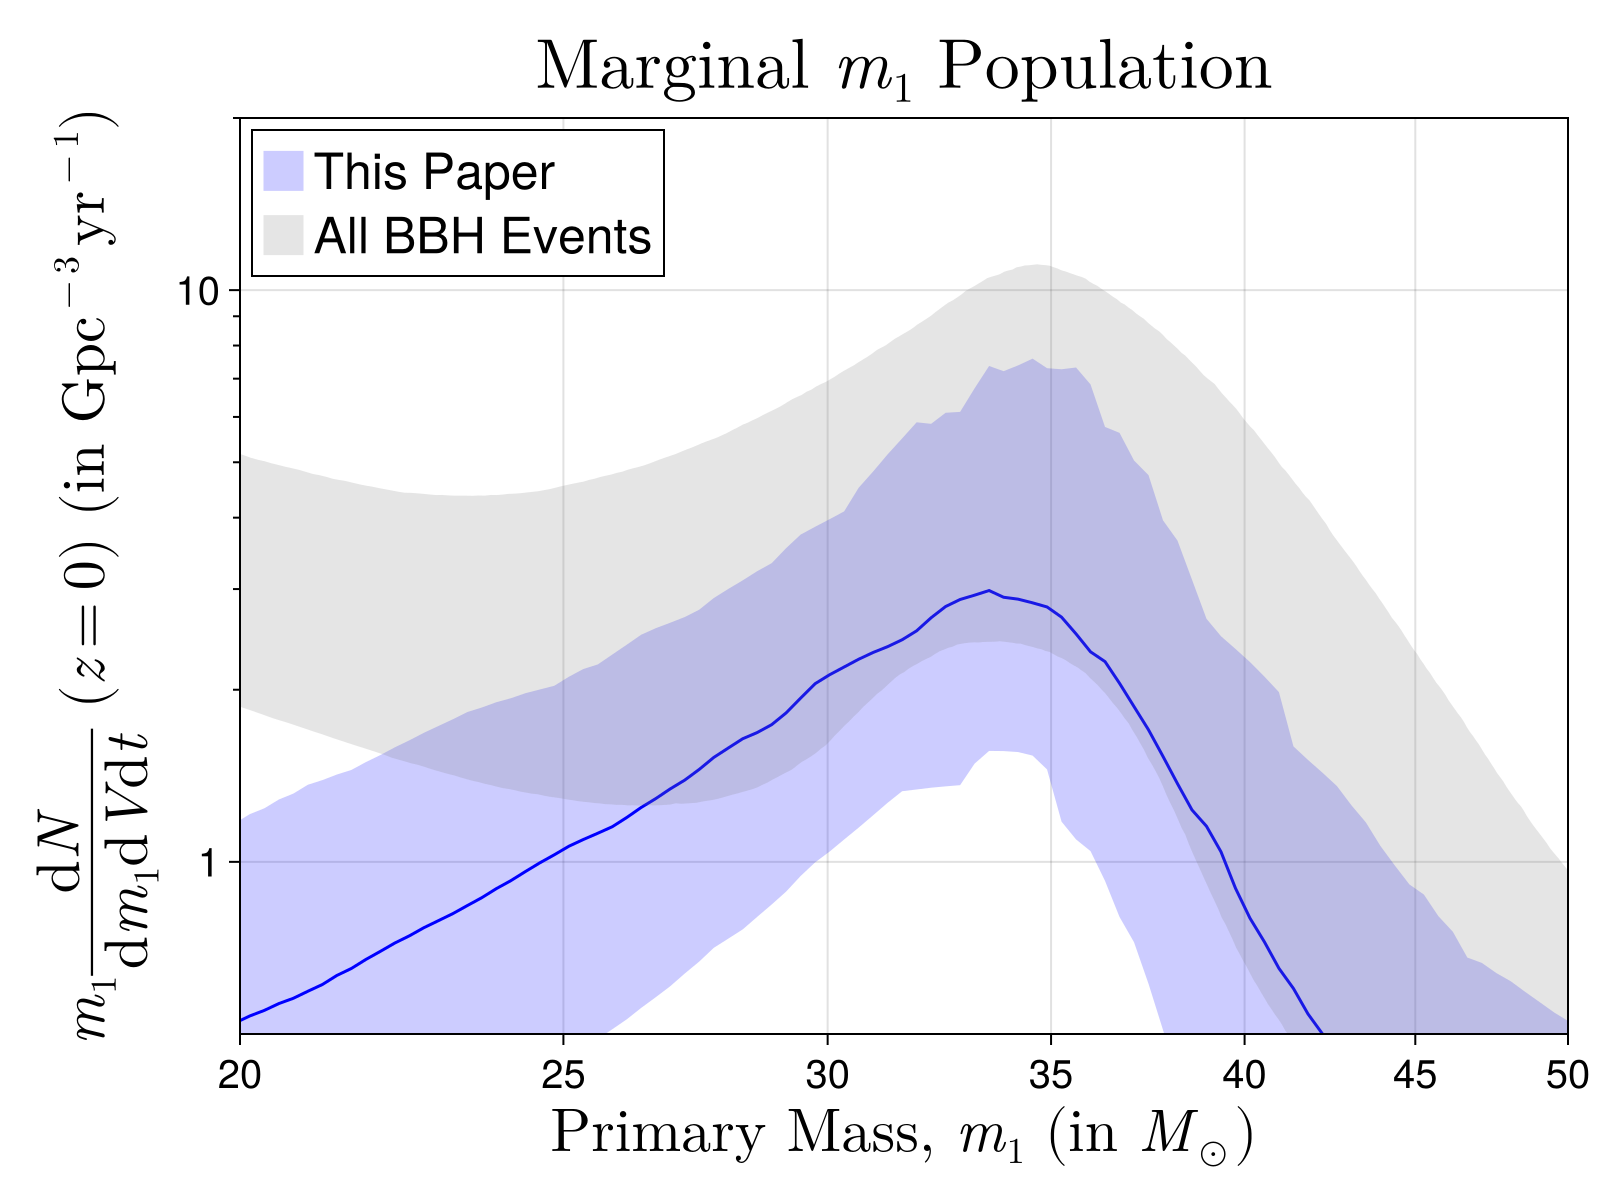

In [8]:
f = marginal_m1_plot_paper(trace)
if plot_save
    save(outdir * "m1_marginal_population.pdf", f, px_per_unit=3)
end
f

## Marginal $q$

In [9]:
z_plot = 0.0
function marginal_q_plot_paper(trace; z_plot=z_plot, ms=exp.(log(m_bh_min):0.01:log(m_bh_max)), qs=collect(range(0.001, stop=1.0, length=100)), draws=100, rng=Random.default_rng(), limits=(0.1, 1, 0.1, 300), yticks=[0.1, 1, 10, 100], yminorticks=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90], color=Makie.wong_colors()[1], savepath=savepath)
    
    f = Figure(size=(800, 600))
    
    a = Axis(f[1,1],
        xlabel = L"\mathrm{Mass~Ratio},~q",
        ylabel = L"\frac{\mathrm{d} N}{\mathrm{d} q \mathrm{d} V \mathrm{d} t}~(z=0)~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
        yscale = log10,
        yticks = yticks,
        yminorticks = yminorticks,
        yminorticksvisible = true,
        ytickformat = "{:.1f}",
        xlabelsize = xlabelsize,
        ylabelsize = ylabelsize,
        xticklabelsize = xticklabelsize,
        yticklabelsize = yticklabelsize,
        titlesize = titlesize,
        title=L"\mathrm{Marginal}~q~\mathrm{Population}",
        limits = limits
    )

    p = trace.posterior
    dNdq_matrix = zeros(length(qs), draws)

    @progress for i in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, span(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdq = map(qs) do q
            integrand = map(ms) do m
                m2 = q * m
                if m2 < m_bh_min
                    zero(m)
                else
                    exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
                end
            end
            p.R[chain=c, draw=d] * trapz(ms, integrand)
        end

        dNdq_matrix[:, i] = dNdq
    end

    # Compute quantiles
    q5 = mapslices(x -> quantile(x, 0.05), dNdq_matrix; dims=2)[:]
    q50 = mapslices(x -> quantile(x, 0.50), dNdq_matrix; dims=2)[:]
    q95 = mapslices(x -> quantile(x, 0.95), dNdq_matrix; dims=2)[:]

    band!(a, qs, q5, q95, color=(:blue, 0.2), label="This Paper")
    lines!(a, qs, q50, color=:blue)

    #Rpq_5_GWTC3   = mapslices(x -> quantile(x, 0.05), Rpq_GWTC3; dims=2) |> vec
    #Rpq_95_GWTC3  = mapslices(x -> quantile(x, 0.95), Rpq_GWTC3; dims=2) |> vec
    #Rpq_med_GWTC3 = mapslices(x -> quantile(x, 0.50), Rpq_GWTC3; dims=2) |> vec

    band!(a, q_GWTC3, Rq_5, Rq_95, color=(:grey, 0.2), label="All BBH Events")
    #lines!(a, q_GWTC3, Rq_med, color=:black, linewidth=2)

    axislegend(a, position = :lt, labelsize = 25, framevisible = true)

    # Save data
    if savepath !== nothing
        h5open(savepath, "r+") do file
            file["q"] = qs
            file["R5_q"] = q5
            file["R50_q"] = q50
            file["R95_q"] = q95
        end
    end

    return f

end

marginal_q_plot_paper (generic function with 1 method)

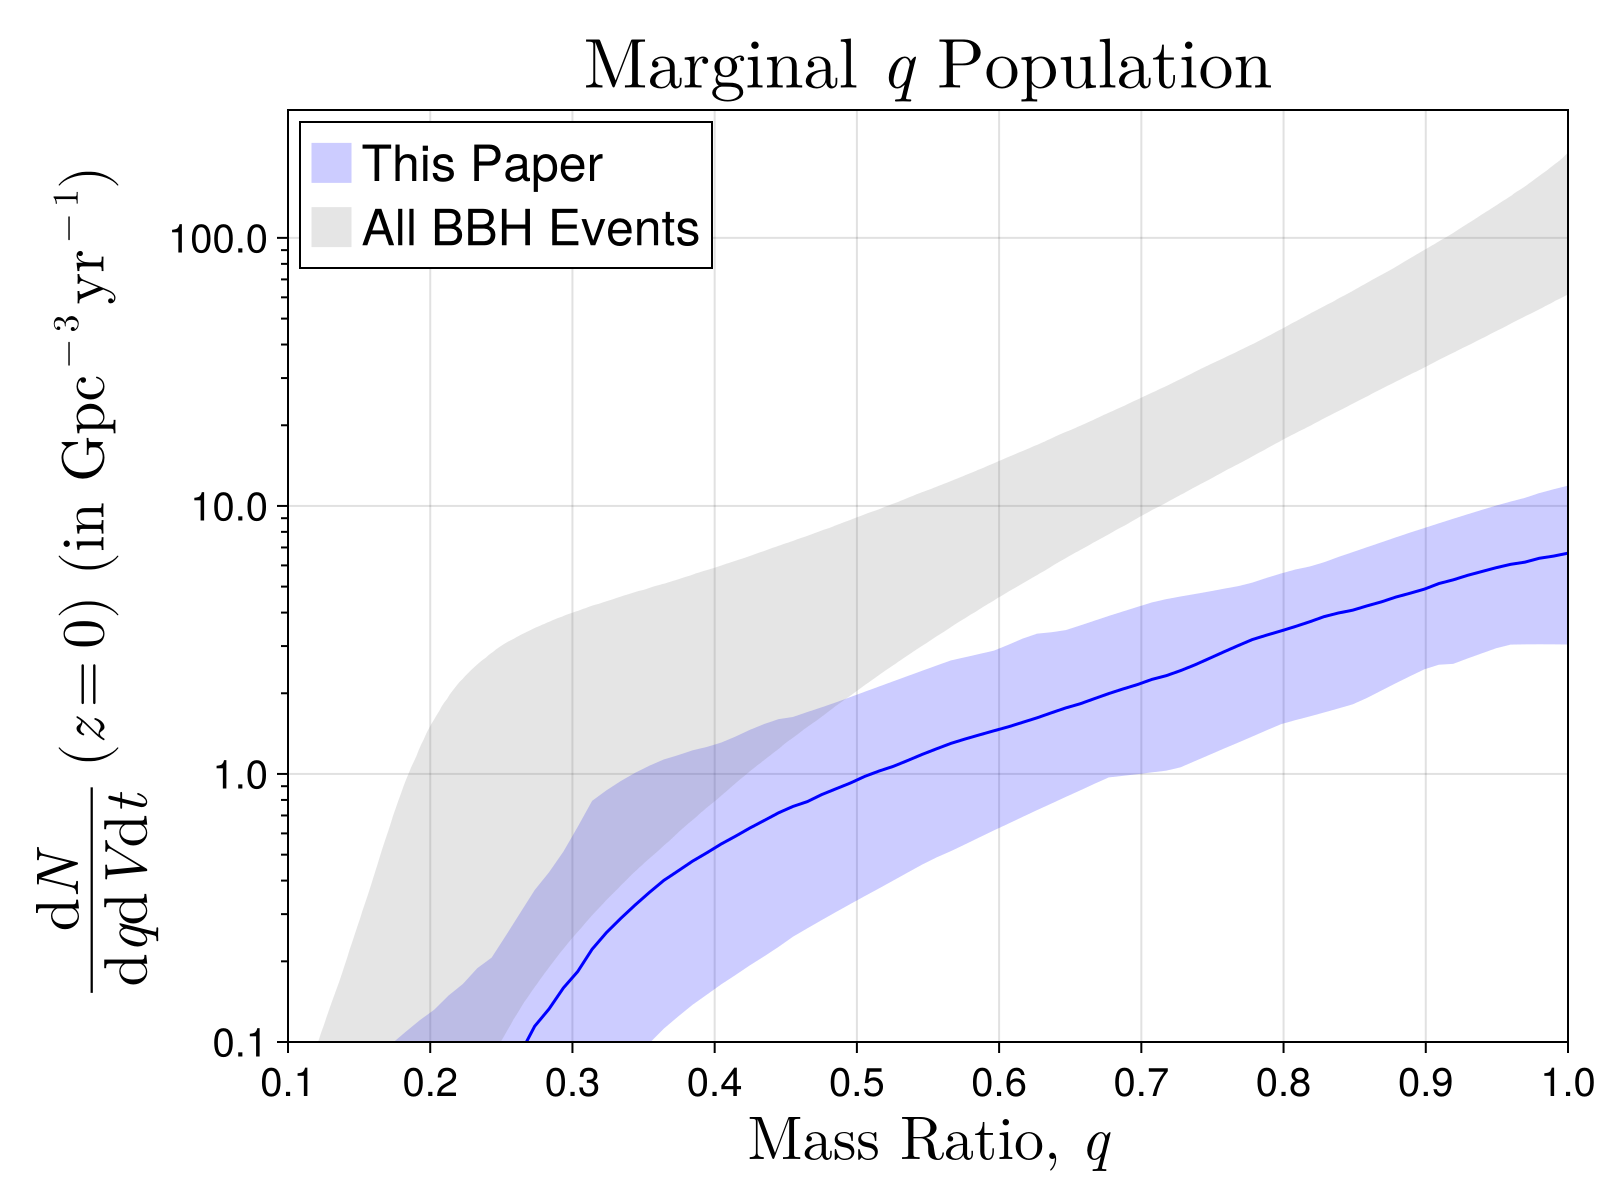

In [10]:
f = marginal_q_plot_paper(trace)
if plot_save
    save(outdir * "q_marginal_population.pdf", f, px_per_unit=3)
end
f

## Marginal $z$

In [11]:
function marginal_z_plot_paper(trace;
    ms = exp.(log(m_bh_min):0.01:log(m_bh_max)),
    qs = 0.001:0.01:1,
    zs = expm1.(range(log(1), stop=log(1 + 2), length=128)),
    draws = 100,
    rng = Random.default_rng(),
    limits = (0, 1.5, 10, 1000),
    yticks = [1, 10, 100, 1000],
    yminorticks = [2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90,200,300,400,500,600,700,800,900],
    plot_md_line = true,
    color = Makie.wong_colors()[1],
    savepath = savepath
)
    f = Figure(size=(800, 650))
    a = Axis(f[1, 1],
        xlabel = L"\mathrm{Redshift},~z",
        ylabel = L"\frac{\mathrm{d} N}{\mathrm{d} V \mathrm{d} t}~(\mathrm{in~}\mathrm{Gpc}^{-3}\mathrm{yr}^{-1})~(\mathrm{Arbitrary~Norm})",
        yscale = log10,
        xlabelsize = xlabelsize,
        ylabelsize = ylabelsize,
        xticklabelsize = xticklabelsize,
        yticklabelsize = yticklabelsize,
        titlesize = titlesize,
        title = L"\mathrm{Marginalized}~z~\mathrm{Population}",
        ytickformat = "{:.0f}",
        yticks = yticks,
        yminorticks = yminorticks,
        yminorticksvisible = true,
        xminorticksvisible = true,
        limits = limits
    )

    p = trace.posterior
    dNs = zeros(length(zs), draws)

    @progress for j in 1:draws
        c = rand(rng, span(dims(p, :chain)))
        d = rand(rng, span(dims(p, :draw)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        z1 = zs[1]
        dNdms = map(ms) do m
            integrand = map(qs) do q
                m2 = q * m
                if m2 < m_bh_min
                    zero(m)
                else
                    exp(log_dN(m, q, 0.0, z1, 0.0; ignore_chi_eff=true))
                end
            end
            trapz(qs, integrand)
        end

        norm = trace.posterior.R[draw=d, chain=c] *
               trapz(ms, dNdms) /
               exp(log_dN(m_plot, q_plot, 0.0, z1, 0.0; ignore_chi_eff=true))

        dNdz = map(zs) do z
            norm * exp(log_dN(m_plot, q_plot, 0.0, z, 0.0; ignore_chi_eff=true))
        end

        dNs[:, j] = dNdz
    end

    norm = 1.5
    PLP_band = band!(a, z_GWTC3, Rz_5 * norm, Rz_95 * norm, color=(:grey, 0.2), label="All BBH Events")

    #imin = argmin(Rz_95 - Rz_5)
    vs = vec(var(log.(dNs), dims=2))
    imin = argmin(vs)
    @show imin
    norm = Rz_med[imin]

    medians = mapslices(median, dNs; dims=2)[:]
    lowers = mapslices(x -> quantile(x, 0.05), dNs; dims=2)[:]
    uppers = mapslices(x -> quantile(x, 0.95), dNs; dims=2)[:]

    band_plot = band!(a, zs, lowers .* norm ./ medians[imin], uppers .* norm ./ medians[imin], color=(:blue, 0.2))
    median_plot = lines!(a, zs, medians .* norm ./ medians[imin], color=:blue, linewidth=2)

    sfr_plot = nothing
    if plot_md_line
        mds = @. (1 + zs)^2.7 / (1 + ((1 + zs)/(1 + 1.9))^5.6)
        mds = mds .* norm ./ mds[imin]

        sfr_plot = lines!(a, zs, mds, color=:black, linestyle=:dash, linewidth=2)
    end

    plots = Any[band_plot, PLP_band]
    labels = ["This Paper", "All BBH Events"]
    if plot_md_line && sfr_plot !== nothing
        push!(plots, sfr_plot)
        push!(labels, "Star Formation Rate")
    end

    axislegend(a, plots, labels; position=:lt, labelsize=25, framevisible=true)

    # Save data if requested
    if savepath !== nothing
        h5open(savepath, "r+") do file
            file["z"] = zs
            file["R5_z"] = lowers .* norm ./ medians[imin]
            file["R50_z"] = medians .* norm ./ medians[imin]
            file["R95_z"] = uppers .* norm ./ medians[imin]
        end
    end
    
    return f
end


marginal_z_plot_paper (generic function with 1 method)

imin = 44


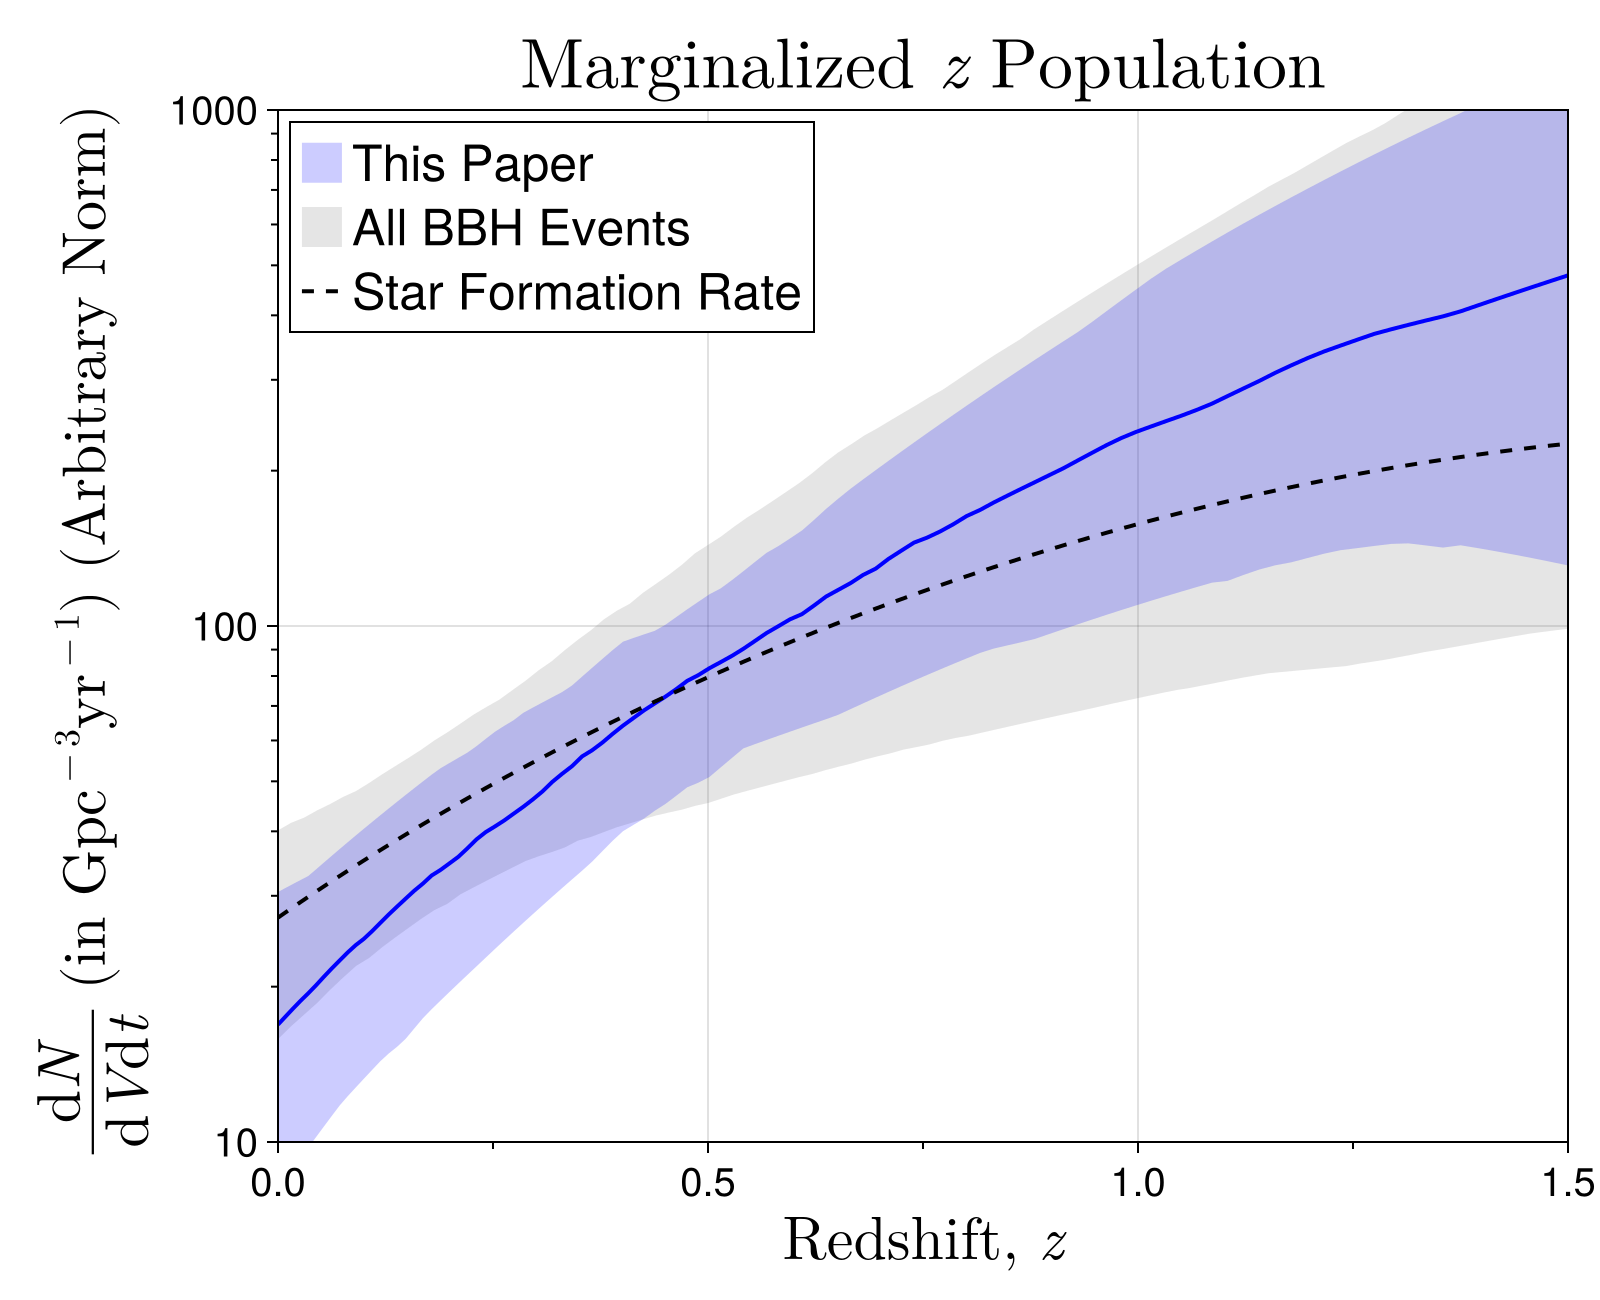

In [12]:
f = marginal_z_plot_paper(trace)
if plot_save
    save(outdir * "z_marginal_population.pdf", f, px_per_unit = 3)
end
f

## Marginal $\chi_{\mathrm{eff}}$

In [13]:
z_plot = 0.0
function chieff_cdf_plot_paper(
    trace;
    z_plot = z_plot,
    chi_effs = collect(-1.0:0.01:1.0),
    qs = collect(0.01:0.01:1.0),
    ms = exp.(range(log(m_bh_min), log(m_bh_max), length=100)),
    draws = 100,
    rng = Random.default_rng(),
    log_dN_from_chain_sample::Function
)
    dchi_eff = chi_effs[2] - chi_effs[1]

    p = trace.posterior
    dNdchi_samples = []

    for _ in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, span(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdchi = map(chi_effs) do chi_eff
            m_integrand = map(ms) do m
                q_integrand = map(qs) do q
                    m2 = q*m
                    if m2 < m_bh_min
                        0.0
                    else
                        exp(log_dN(m, q, chi_eff, z_plot, 0.0))
                    end
                end
                trapz(qs, q_integrand)
            end
            p.R[draw=d, chain=c] * trapz(ms, m_integrand)
        end

        cdf = cumsum(dNdchi)
        cdf ./= cdf[end]  # normalize
        push!(dNdchi_samples, cdf)
    end

    cdf_matrix = reduce(hcat, dNdchi_samples)
    cdf_median = mapslices(x -> quantile(x, 0.5), cdf_matrix; dims=2)[:]
    cdf_p10    = mapslices(x -> quantile(x, 0.10), cdf_matrix; dims=2)[:]
    cdf_p90    = mapslices(x -> quantile(x, 0.90), cdf_matrix; dims=2)[:]

    fig = Figure(size=(800, 600))
    ax = Axis(fig[1, 1],
        xlabel=L"\mathrm{Effective~Spin},~\chi_\mathrm{eff}",
        ylabel=L"\mathrm{CDF}",
        xlabelsize=xlabelsize, ylabelsize=ylabelsize,
        xticklabelsize = xticklabelsize, yticklabelsize = yticklabelsize,
        titlesize = titlesize, title=L"\mathrm{CDF~of~} \chi_\mathrm{eff} \mathrm{~at}~z=0",
        xgridvisible=true, ygridvisible=true,
        limits = (-0.5, 0.5, 0.0, 1.0)
    )

    b = band!(ax, chi_effs, cdf_p10, cdf_p90, color=(:blue, 0.2), label="This Paper")
    l = lines!(ax, chi_effs, cdf_median, color=:blue, linewidth=2)

    band!(ax, chieff_GWTC3, Rchieff_cdf_5/Rchieff_cdf_5[end], Rchieff_cdf_95/Rchieff_cdf_95[end], color=(:grey, 0.3), label="All BBH Events")

    vlines!(ax, [0.0], color=:black, linestyle=:dash, linewidth=2)
    
    axislegend(ax, position = :lt, labelsize = 25, framevisible = true)
    fig
end


chieff_cdf_plot_paper (generic function with 1 method)

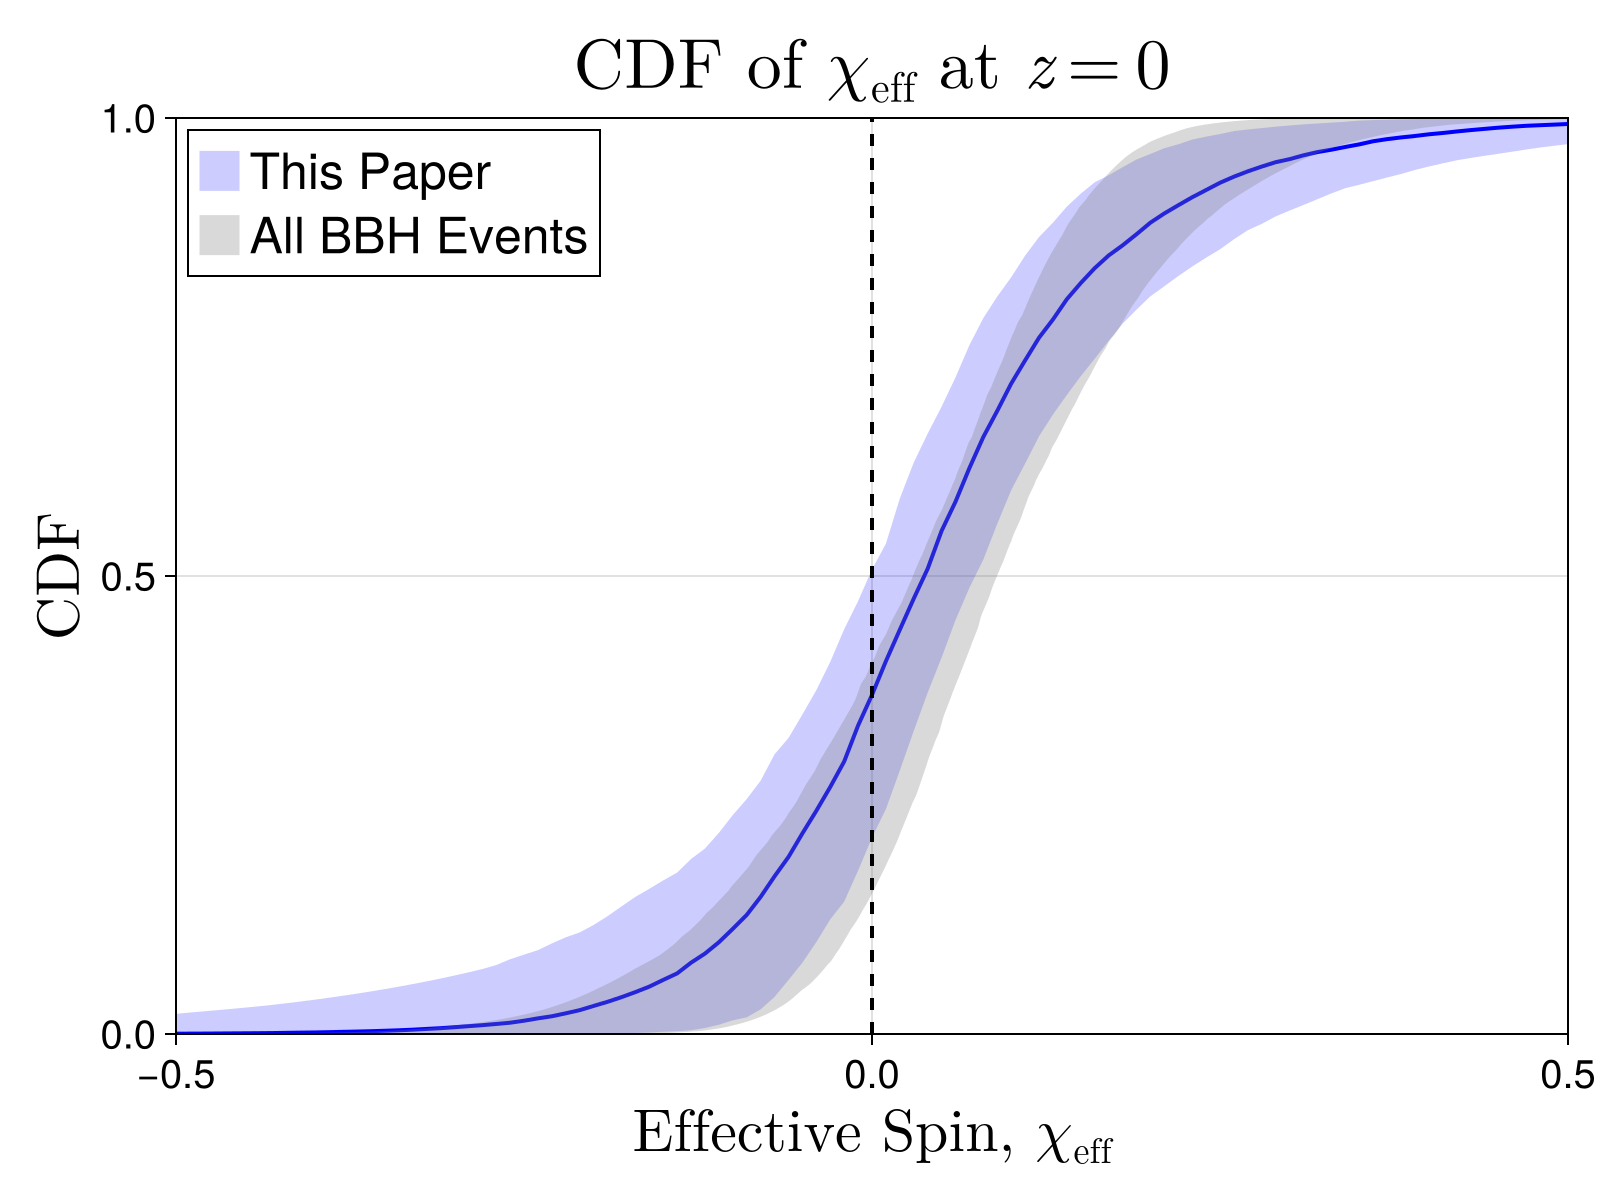

In [14]:
f = chieff_cdf_plot_paper(
    trace;
    draws=200,
    log_dN_from_chain_sample=log_dN_from_chain_sample
)
if plot_save
    save(outdir * "cdf_chieff.pdf", f, px_per_unit = 3)
end
f

In [15]:
function chieff_save_data(trace; z_plot=z_plot, ms=exp.(log(m_bh_min):0.01:log(m_bh_max)), qs=collect(0.001:0.01:1), chi_effs=(-1:0.01:1), draws=100, rng=Random.default_rng(), savepath=savepath)

    p = trace.posterior
    dNdchi_matrix = zeros(length(chi_effs), draws)

    @progress for i in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, span(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdchi = map(chi_effs) do chi_eff
            m_integrand = map(ms) do m
                q_integrand = map(qs) do q
                    m2 = q * m
                    if m2 < m_bh_min
                        zero(m)
                    else
                        exp(log_dN(m, q, chi_eff, z_plot, 0.0))
                    end
                end
                trapz(qs, q_integrand)
            end
            p.R[draw=d, chain=c] * trapz(ms, m_integrand)
        end

        dNdchi_matrix[:, i] = dNdchi
    end

    # Compute quantiles
    q5 = mapslices(x -> quantile(x, 0.05), dNdchi_matrix; dims=2)[:]
    q50 = mapslices(x -> quantile(x, 0.50), dNdchi_matrix; dims=2)[:]
    q95 = mapslices(x -> quantile(x, 0.95), dNdchi_matrix; dims=2)[:]

    # Save to HDF5
    if savepath !== nothing
        h5open(savepath, "r+") do file
            file["chi_eff"] = collect(chi_effs)
            file["R5_chi_eff"] = q5
            file["R50_chi_eff"] = q50
            file["R95_chi_eff"] = q95
        end
    end

    return 1
end


chieff_save_data (generic function with 1 method)

In [16]:
chieff_save_data(trace)

1

## $q-\chi_{\mathrm{eff}}$ Population

In [17]:
z_plot = 0.0

function q_chieff_contour_plot_paper(trace;
    m_plot = m_plot,
    z_plot = z_plot,
    chi_effs = collect(-1.0:0.01:1.0),
    qs = collect(range(0.001, stop=1.0, length=100)),
    levels = range(0.1, stop=1.0, length=10),
    draws = 100,
    rng = Random.default_rng(),
    limits = (-0.6, 0.5, 0.5, 1.0),
    log_dN_from_chain_sample::Function
)
    f = Figure(size=(800, 700))
    ax = Axis(f[1, 1],
        xlabel = L"\mathrm{Effective~Spin},~\chi_\mathrm{eff}",
        ylabel = L"\mathrm{Mass~Ratio},~q",
        xlabelsize = xlabelsize,
        ylabelsize = ylabelsize,
        xticklabelsize = xticklabelsize,
        yticklabelsize = yticklabelsize,
        titlesize = titlesize,
        title=L"q-\chi_\mathrm{eff} \mathrm{~Corner~Plot~at}~m_1=35M_{\odot},~z=0",
        xgridvisible = true,
        ygridvisible = true,
        limits = limits,
        xticks = vcat(-0.5:0.25:0.5, [-0.25, 0.25]) 
    )

    dchi_eff = chi_effs[2] - chi_effs[1]
    dq = qs[2] - qs[1]
    p = trace.posterior

    pqc_mean = [0.0 for ce in chi_effs, q in qs]
    N = length(dims(p, :chain)) * length(dims(p, :draw))
    i = 0

    @withprogress begin
        for c in span(dims(p, :chain))
            for d in span(dims(p, :draw))
                log_dN = log_dN_from_chain_sample(trace, d, c)

                pqc = [
                    if q * m_plot > m_bh_min
                        exp(log_dN(m_plot, q, ce, z_plot, 0.0))
                    else
                        0.0
                    end
                    for ce in chi_effs, q in qs
                ]

                pqc ./= sum(pqc) * dchi_eff * dq
                pqc_mean .+= pqc

                i += 1
                @logprogress i / N
            end
        end
        pqc_mean ./= N
    end

    # Normalize contour levels
    flat_vals = sort(vec(pqc_mean))
    cum_vals = cumsum(flat_vals) ./ sum(flat_vals)
    level_vals = [flat_vals[argmin(abs.(cum_vals .- l))] for l in levels]

    # Use a blue colormap with lower alpha
    blue_colormap = cgrad(:blues, alpha=0.7)

    contourf!(ax, chi_effs, qs, pqc_mean; levels=level_vals, colormap=blue_colormap)

    return f
end

q_chieff_contour_plot_paper (generic function with 1 method)

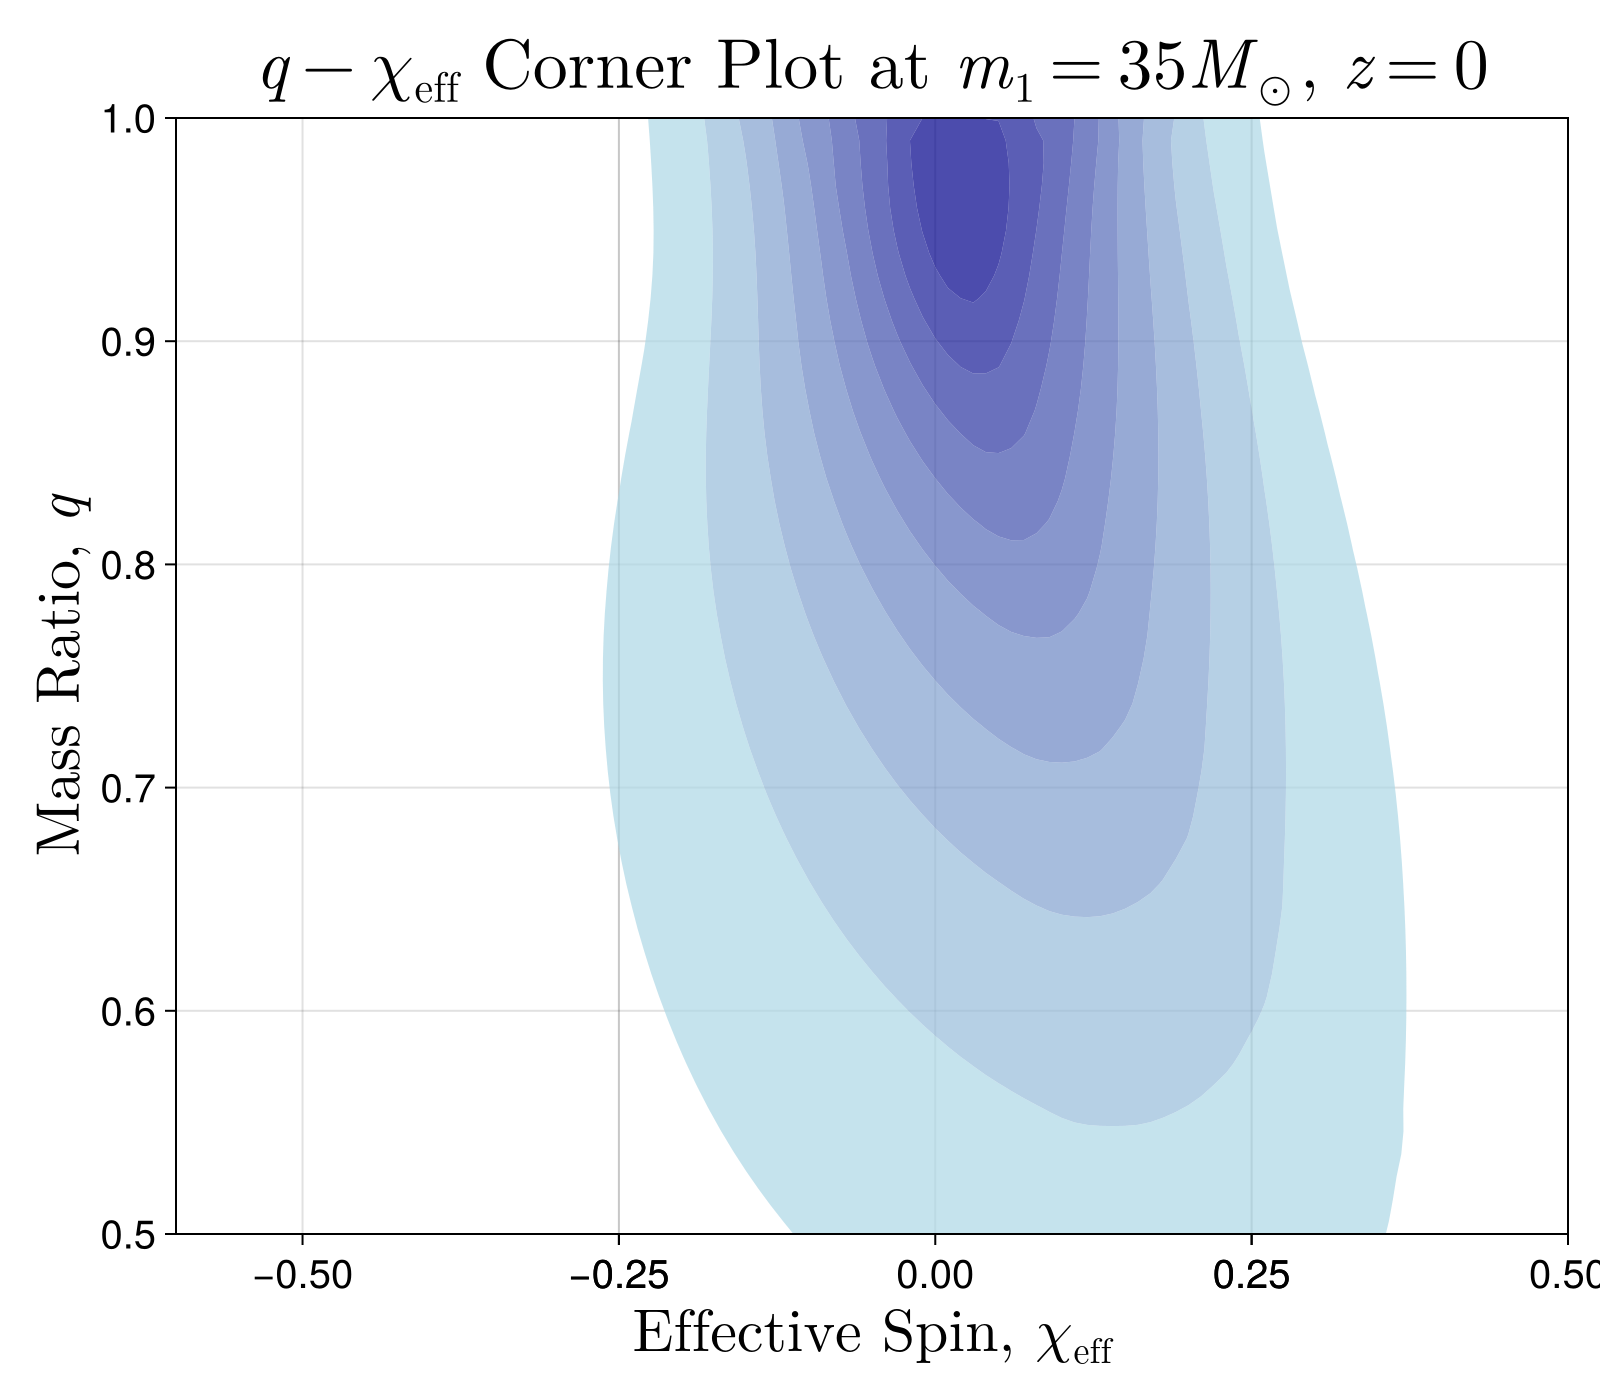

In [18]:
f = q_chieff_contour_plot_paper(trace; draws=200, log_dN_from_chain_sample=log_dN_from_chain_sample)
if plot_save
    save(outdir * "q_chieff_population.pdf", f, px_per_unit = 3)
end
f

In [19]:
using JSON

datafile = "../../m1m2_cut/data/posteriors_samples_spin_vs_q_FAR_1_in_1.json"

# Load and parse JSON
data = open(datafile, "r") do io
    JSON.parse(IOBuffer(read(io, String)))
end

# Extract arrays
mu0s_GWTC3 = collect(data["chiEff_mean"])
logsig0s_GWTC3 = collect(data["chiEff_logstd"])
alphas_GWTC3 = collect(data["chi_alpha"])
betas_GWTC3 = collect(data["chi_beta"])

# Now this works
println(alphas_GWTC3)

Any[-0.6187577990282505, -0.3665687554986094, -0.43170304172106994, -0.4458879425880223, -0.5552287649708043, -0.013224973453175526, -0.6236950307799525, -0.4114661436846288, -0.3585606522650463, -0.210298958475528, -0.3802541540519829, -0.3150716321539814, -0.4622877318193236, -0.3909422053008625, -0.1538761785773398, -0.3245207112326657, -0.4212053159183198, -0.34649758884098847, -0.4132643320511382, 0.025979902320315856, -0.4643290247567956, -0.31028750681582074, -0.34108996096540617, -0.2432736461892496, -0.03295931198510238, -0.250372861050553, -0.2317140814887447, -0.4038171182001511, -0.1296791469610811, -0.3838223315612324, -0.21979027967663003, -0.5529308450137498, -0.38253926267348554, -0.6441512443041341, -0.7994179337108419, -0.42257410321209227, -0.3193153771954787, -0.3526957289070395, -0.4454383024571585, -0.4931752664564624, -0.26753365507897264, -0.32903218274095136, 0.0074704822048332065, -0.14529358577828877, -0.4004436397989691, -0.3532935752294626, -0.2841151237939

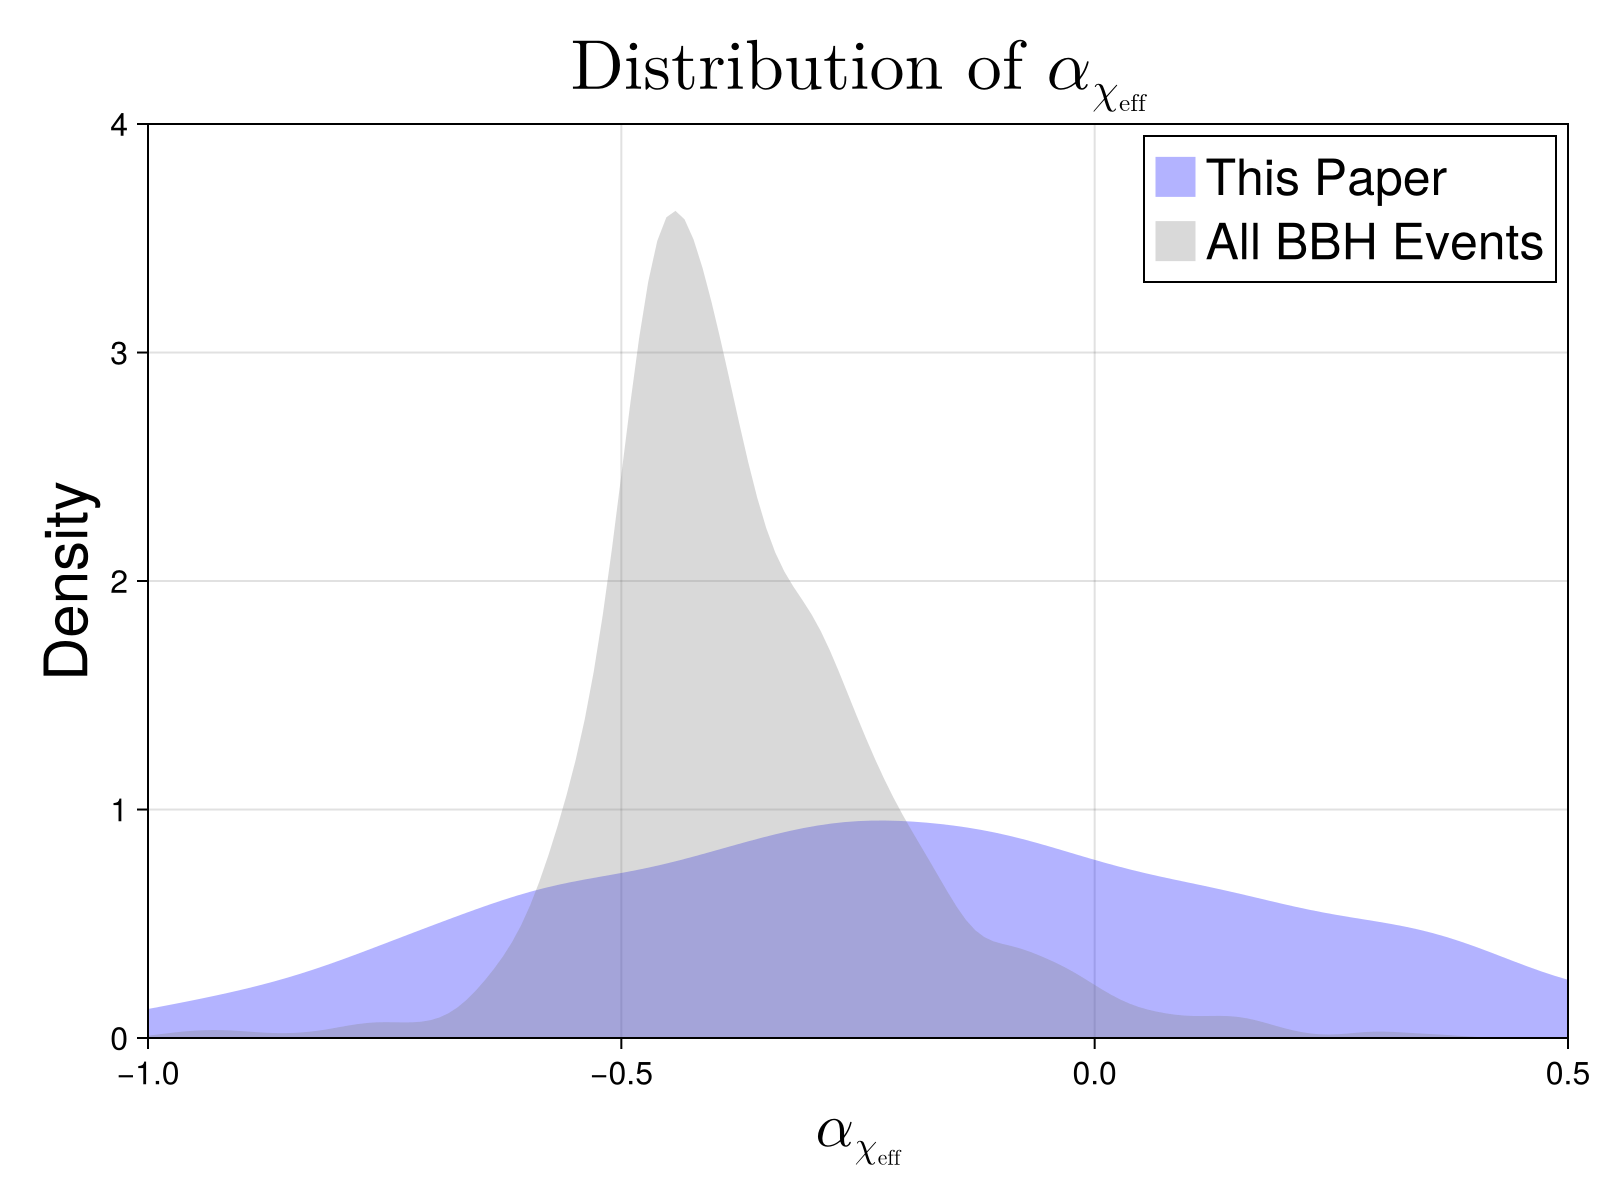

In [20]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1], xlabel=L"\alpha_{\chi_{\mathrm{eff}}}", ylabel="Density", xlabelsize=30, ylabelsize=30,
xticklabelsize = 16, yticklabelsize = 16,
titlesize=35, title=L"\mathrm{Distribution~of}~\alpha_{\chi_{\mathrm{eff}}}", limits = (-1.0, 0.5, 0, 4),)
density!(ax, vec(trace.posterior.alpha_chi_eff), color=(:blue, 0.3), label="This Paper")
density!(ax, alphas_GWTC3, color=(:grey, 0.3), label="All BBH Events")
axislegend(ax, position = :rt, labelsize = 25, framevisible = true)
if plot_save
    save(outdir * "alpha_chieff.pdf", fig, px_per_unit = 3)
end
fig

## Print Median, 5% and 95% Values

In [21]:
function summarize_trace(trace)
    println("Parameter\tMedian\t5%\t95%")
    for (name, values) in pairs(trace.posterior)
        flat_values = vec(Array(values))  # Flatten all chains and draws into a 1D array
        median_val = median(flat_values)
        lower_val = quantile(flat_values, 0.05)
        upper_val = quantile(flat_values, 0.95)
        println("$(name)\t$(round(median_val, sigdigits=5))\t$(round(median_val-lower_val, sigdigits=5))\t$(round(upper_val-median_val, sigdigits=5))")
    end
end

summarize_trace (generic function with 1 method)

In [22]:
summarize_trace(trace)

Parameter	Median	5%	95%
alpha	-1.4586	2.2399	2.6002
m1_draw	34.286	8.4966	16.817
mul	0.19443	0.68143	0.53877
Neff_samps	63.086	44.378	881.33
mtr	29.117	3.5664	4.6526
lambda	3.839	1.5171	1.9169
m2s	29.473	9.3024	7.8188
qs	0.86798	0.32761	0.11674
kappa	5.4624	2.2085	2.275
sigma	3.3115	2.1392	5.1035
sigmal	0.39175	0.31841	0.45138
alphahm	2.5961	2.3024	2.8651
R	8.2768	6.99	27.203
m1s	34.435	8.7798	20.25
chi_eff_draw	0.05549	0.19287	0.2857
rhm	0.083276	0.066705	0.29249
q_draw	0.86684	0.35306	0.12269
Neff_sel	3942.6	1973.5	2841.3
muh	0.0151	0.10218	0.10929
beta	6.8739	5.1816	2.7969
mbhmax	34.273	3.5724	2.5189
beta_chi_eff	-0.348	0.46741	0.34732
chi_effs	0.051602	0.17781	0.28505
sigmah	0.037762	0.034895	0.082208
zs	0.42662	0.29625	0.54273
log_rhm	-2.4856	1.6145	1.5068
alpha_chi_eff	-0.18071	0.62283	0.78627
m2_draw	29.282	10.698	8.4941
z_draw	0.44096	0.29839	0.48076
zp	2.5347	1.3622	1.3007


# Astrophysical Interpretation

## 2G-2G Merger
## $\mu$ and $\sigma$ of $\chi_{\mathrm{eff}}$ at $q=1$

### Expected Distribution of $\chi_{\mathrm{eff}}$ for 2G-2G BBH Merger:

$$
\chi_{\mathrm{eff}} = \frac{\chi_1\cos \theta_1 + q \chi_2\cos \theta_2}{1+q}
$$

The width:
$$
\Rightarrow \mathrm{var}(\chi_{\mathrm{eff}}) = \mathrm{var}\Bigg(\frac{\chi_1\cos \theta_1 + q \chi_2\cos \theta_2}{1+q}\Bigg)
$$

For 2G-2G merger, $q\approx 1, ~\chi_1 \approx 0.7,~\chi_2 \approx 0.7,~\mathrm{cov}(\chi_1\cos\theta_1, \chi_2\cos\theta_2) \approx 0$

$$
\Rightarrow \mathrm{std}(\chi_{\mathrm{eff}}) = \frac{1}{(1+q)}(\mathrm{var}(\chi_1\cos\theta_1) + q^2\mathrm{var}(\chi_2\cos\theta_2)+2q\mathrm{cov}(\chi_1\cos\theta_1, \chi_2\cos\theta_2))^{\frac{1}{2}} \approx \frac{0.7}{2}(\mathrm{var}(\cos\theta_1) + \mathrm{var}(\cos\theta_2))^{\frac{1}{2}}
$$

Now $\cos\theta_1 = U(-1,1)$ and $\cos\theta_2 = U(-1,1)$. So,

$$
\Rightarrow \mathrm{std}(\chi_{\mathrm{eff}}) \approx \frac{0.7}{2}\Bigg(\frac{4}{12}+\frac{4}{12}\Bigg)^{\frac{1}{2}} = \frac{0.7\sqrt{2}}{\sqrt{12}} = 0.28
$$

The mean:

$$
\mathrm{E}(\chi_{\mathrm{eff}}) = \mathrm{E}\Bigg(\frac{\chi_1\cos \theta_1 + q \chi_2\cos \theta_2}{1+q}\Bigg) \approx \frac{\mathrm{E}(\chi_1\cos\theta_1)+\mathrm{E}(\chi_2\cos\theta_2)}{2} = 0
$$

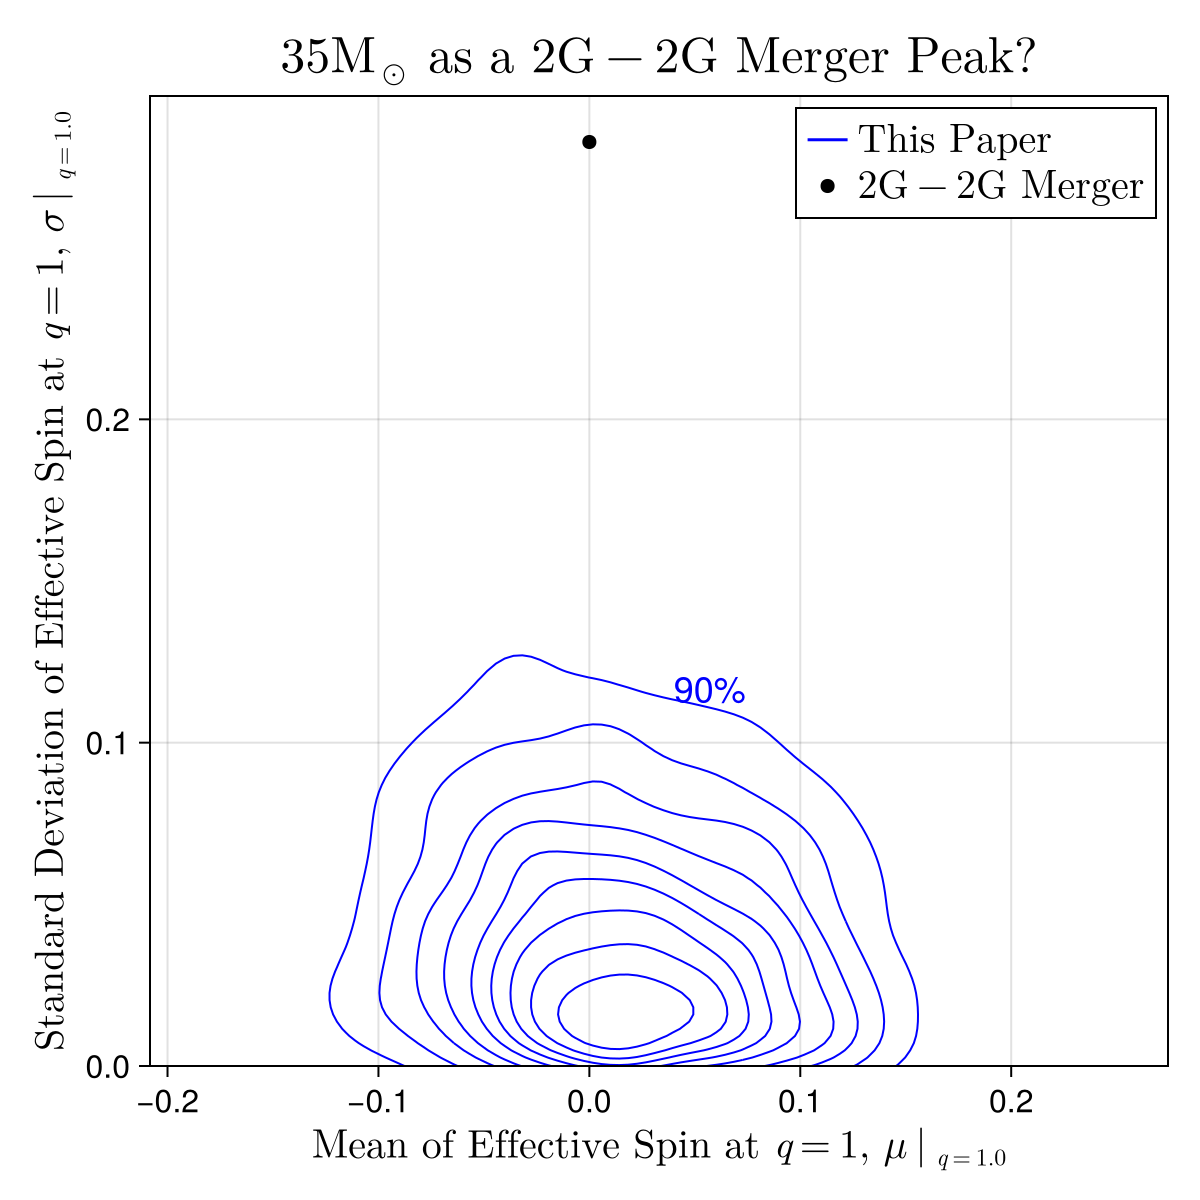

In [23]:
# 2g2g mu-sigma versus our fit
std_2g2g = 0.7*sqrt(2)/sqrt(12)

q_2g2g = 1.0  # For 2g2g mergers

# Evaluate posterior samples at q = 1
xvals = chieff_interp.(q_2g2g, vec(trace.posterior.mul), vec(trace.posterior.muh))
yvals = chieff_interp.(q_2g2g, vec(trace.posterior.sigmal), vec(trace.posterior.sigmah))

xlims = extrema(xvals)
ylims_manual = (0.0, 0.3)

f = Figure(size=(600, 600))

ax = Axis(f[1, 1],
    xlabel = L"\mathrm{Mean~of~Effective~Spin~at}~q=1,~\mu \mid_{q=%$(q_2g2g)}",
    ylabel = L"\mathrm{Standard~Deviation~of~Effective~Spin~at}~q=1,~\sigma \mid_{q=%$(q_2g2g)}",
    xlabelsize = 20,
    ylabelsize = 20,
    xticklabelsize = 16,
    yticklabelsize = 16,
    titlesize = 25,
    title = L"35\mathrm{M}_{\odot}~\mathrm{as~a~2G-2G~Merger~Peak?}",
    limits = (xlims, ylims_manual)
    )

kdecontour!(ax, xvals, yvals, levels = 0.1:0.1:0.9, color = :blue)

scatter!(ax, [0.0], [std_2g2g], color = :black, markersize = 10)

legend_line = lines!([NaN], [NaN], color = :blue)
legend_dot = scatter!([NaN], [NaN], color = :black, markersize = 10)

axislegend(ax, [legend_line, legend_dot],
    [L"\mathrm{This~Paper}", L"\mathrm{2G-2G~Merger}"],
    position = :rt,
    labelsize = 20,
    framevisible = true
)

text!(ax, "90%", position = (0.04, 0.11), align = (:left, :bottom), fontsize = 18, color = :blue)

if plot_save
    save(outdir * "2G2G.pdf", f, px_per_unit = 3)
end
f

## 2G-1G Merger
## $\mu$ and $\sigma$ of $\chi_{\mathrm{eff}}$ at $q=0.5$

### Expected Distribution of $\chi_{\mathrm{eff}}$ for 2G-1G BBH Merger:

$$
\chi_{\mathrm{eff}} = \frac{\chi_1\cos \theta_1 + q \chi_2\cos \theta_2}{1+q}
$$

The width:
$$
\Rightarrow \mathrm{var}(\chi_{\mathrm{eff}}) = \mathrm{var}\Bigg(\frac{\chi_1\cos \theta_1 + q \chi_2\cos \theta_2}{1+q}\Bigg)
$$

We assume, $\mathrm{cov}(\chi_1\cos\theta_1, \chi_2\cos\theta_2) \approx 0$.

$$
\Rightarrow \mathrm{std}(\chi_{\mathrm{eff}}) \approx \frac{1}{(1+q)}(\mathrm{var}(\chi_1\cos\theta_1) + q^2\mathrm{var}(\chi_2\cos\theta_2))^{\frac{1}{2}}
$$

Massive BH is 2G: $\chi_1 = 0.7,~q=0.5$.

$$
\Rightarrow \mathrm{std}(\chi_{\mathrm{eff}}) \approx \frac{1}{(1+0.5)}(0.7^2\mathrm{var}(\cos\theta_1) + 0.5^2\mathrm{var}(\chi_2\cos\theta_2))^{\frac{1}{2}} \geq \frac{0.7}{1.5}(\mathrm{var}(\cos\theta_1))^{\frac{1}{2}}
$$

The equality holds for $\chi_2=0$.

Now $\cos\theta_1 = U(-1,1)$. So,

$$
\Rightarrow \mathrm{std}(\chi_{\mathrm{eff}}) \geq \frac{0.7}{1.5}\Bigg(\frac{4}{12}\Bigg)^{\frac{1}{2}} = 0.27
$$

The mean:

$$
\mathrm{E}(\chi_{\mathrm{eff}}) = \mathrm{E}\Bigg(\frac{\chi_1\cos \theta_1 + q \chi_2\cos \theta_2}{1+q}\Bigg) \approx \frac{0.7\mathrm{E}(\cos\theta_1)+\mathrm{E}(\chi_2\cos\theta_2)}{1.5}
$$

Unlike variance, there is no lower bound of mean. If $\chi_2=0$:

$$
\mathrm{E}(\chi_{\mathrm{eff}}) = 0
$$

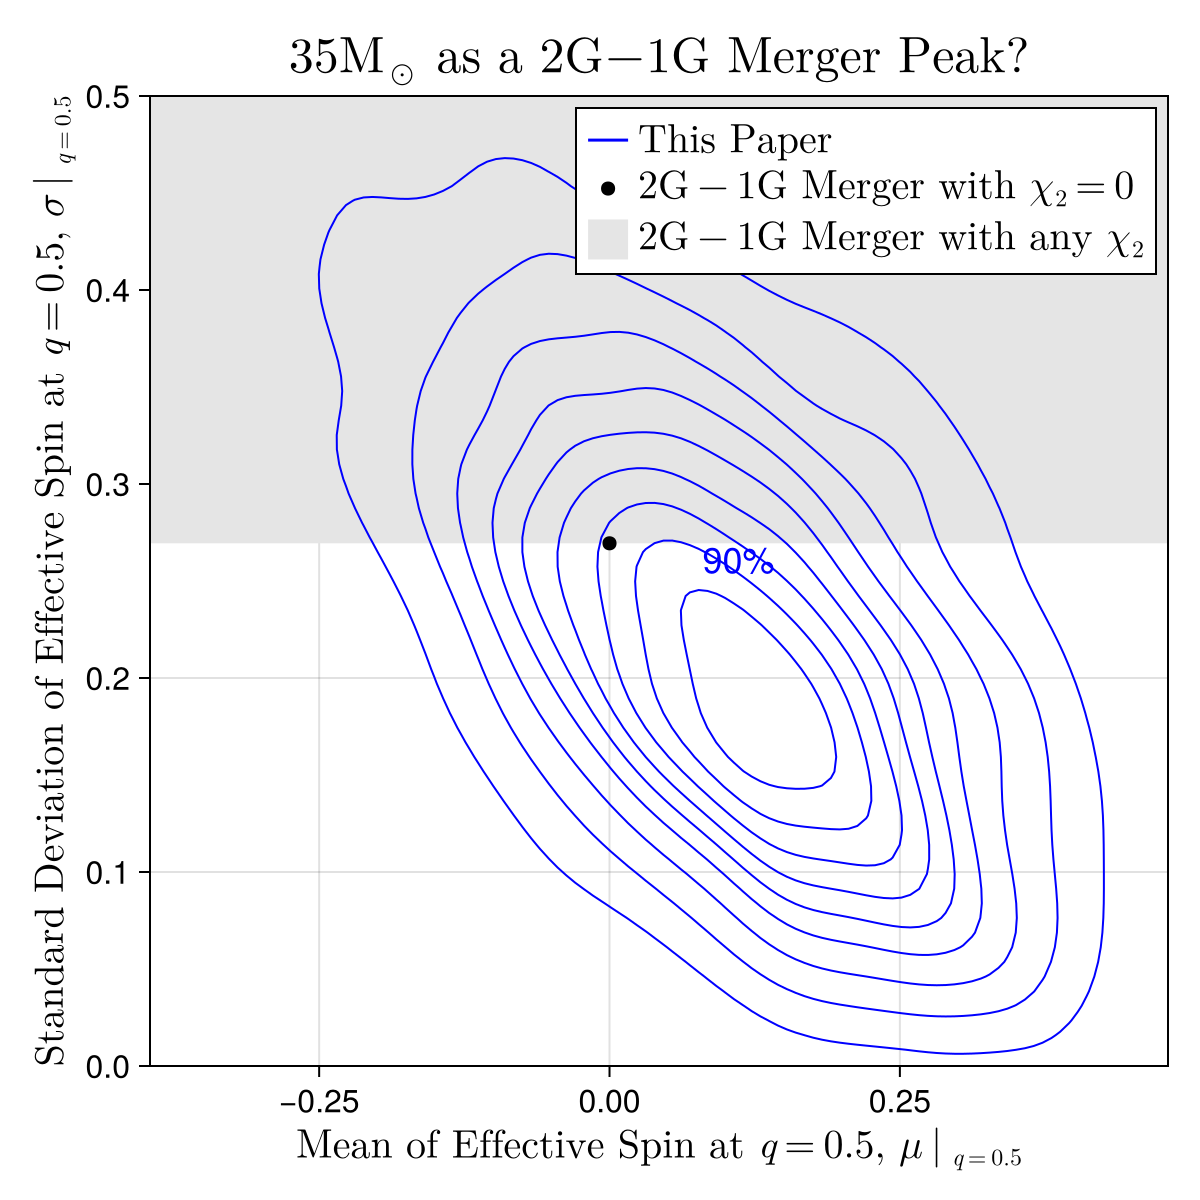

In [24]:
# Parameters for the 2G–1G merger
std_2g1g = 0.7/1.5*(2/sqrt(12))
q_2g1g = 0.5

# Evaluate posterior samples at q = 0.5
xvals = chieff_interp.(q_2g1g, vec(trace.posterior.mul), vec(trace.posterior.muh))
yvals = chieff_interp.(q_2g1g, vec(trace.posterior.sigmal), vec(trace.posterior.sigmah))

xlims = extrema(xvals)
ylims_manual = (0.0, 0.5)

f = Figure(size = (600, 600))

ax = Axis(f[1, 1],
    xlabel = L"\mathrm{Mean~of~Effective~Spin~at}~q=0.5,~\mu \mid_{q=%$(q_2g1g)}",
    ylabel = L"\mathrm{Standard~Deviation~of~Effective~Spin~at}~q=0.5,~\sigma \mid_{q=%$(q_2g1g)}",
    xlabelsize = 20,
    ylabelsize = 20,
    xticklabelsize = 16,
    yticklabelsize = 16,
    titlesize = 25,
    title = L"35\mathrm{M}_{\odot}~\mathrm{as~a~2G\!-\!1G~Merger~Peak?}",
    limits = (xlims, ylims_manual)
)

band!(ax,
    [xlims[1], xlims[2]],
    [std_2g1g, std_2g1g],
    [ylims_manual[2], ylims_manual[2]],
    color = (:grey90, 1),
    label = L"\mathrm{2G-1G~Merger~with~any}~\chi_2"
)

kdecontour!(ax, xvals, yvals, levels = 0.1:0.1:0.9, color = :blue)

scatter!(ax, [0.0], [std_2g1g], color = :black, markersize = 10)

legend_line = lines!([NaN], [NaN], color = :blue)
legend_dot = scatter!([NaN], [NaN], color = :black, markersize = 10)
legend_grey = band!([NaN, NaN], [NaN, NaN], [NaN, NaN], color = (:grey90, 1))

axislegend(ax,
    [legend_line, legend_dot, legend_grey],
    [L"\mathrm{This~Paper}", L"\mathrm{2G-1G~Merger~with}~\chi_2=0", L"\mathrm{2G-1G~Merger~with~any}~\chi_2"],
    position = :rt,
    labelsize = 20,
    framevisible = true
)

text!(ax, "90%", position = (0.08, 0.25), align = (:left, :bottom), fontsize = 18, color = :blue)

if plot_save
    save(outdir * "2G1G.pdf", f, px_per_unit = 3)
end
f


In [25]:
println(0.7*sqrt(2)/sqrt(12))
println(0.7/1.5*(2/sqrt(12)))

0.28577380332470415
0.2694301256218254


#### Check How Well Can We Model Uniform by a Normal Distribution (For 2G-1G BH):

In [26]:
Random.seed!(42)

true_dist = Uniform(-0.27 * sqrt(3), 0.27 * sqrt(3))
samples = rand(true_dist, 1000000)

fitted_dist = fit(Normal, samples)

println("Fitted Normal Distribution:")
println("mean  = ", round(mean(fitted_dist), digits=10))
println("std   = ", round(std(fitted_dist), digits=10))

Fitted Normal Distribution:
mean  = -0.000439746
std   = 0.2700742457


#### They are same!